![](images/ohm_logo.png)

<h1><center>Bachelor Thesis</center></h1>

<h1><center><big>IT-Based textgeneration using NLP methods</big><br><hr> <i>State-of-the-art and design of a prototype </i></center></h1>

<center>from Tim Löhr</center>

# 1.0 Importing the Dependcies

In [ ]:
from attention import AttentionLayer

import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup

from nltk.corpus import stopwords   
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras import backend as K 

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model, model_from_json

from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt

import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

# 2.0 Loading the Data

In [2]:
data = pd.read_csv('amazon-fine-food-reviews/Reviews.csv', nrows=10000)
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


In [3]:
data.shape

(10000, 10)

# 3.0 Data Preprocessing

In [4]:
data = data[['Summary', 'Text']]

In [5]:
data.drop_duplicates(subset='Text')
data.dropna(axis=0, inplace=True)

In [6]:
data.shape

(10000, 2)

### Contraction Mapping

In [7]:
from contraction_mapping import contraction_mapping

contraction_mapping = contraction_mapping()

## Cleaning

### Text Cleaning

In [8]:
stop_words = stopwords.words('english')
tokenizer = RegexpTokenizer(r'\w+')

def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [9]:
#text_cleaner(data['Text'][127])

In [10]:
#data['Text'][127]

#### Cleaned text concatenate with DataFrame

In [11]:
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

### Summary Cleaning

In [12]:
data['Summary'][:10]

0                            Good Quality Dog Food
1                                Not as Advertised
2                            "Delight" says it all
3                                   Cough Medicine
4                                      Great taffy
5                                       Nice Taffy
6    Great!  Just as good as the expensive brands!
7                           Wonderful, tasty taffy
8                                       Yay Barley
9                                 Healthy Dog Food
Name: Summary, dtype: object

In [13]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

In [14]:
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x: '_START_ ' + x + ' _END_')

In [15]:
data.head()

,Summary,Text,cleaned_text,cleaned_summary
0,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,_START_ good quality dog food _END_
1,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".",product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,_START_ not as advertised _END_
2,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...",confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat famil...,_START_ delight says it all _END_
3,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal,_START_ cough medicine _END_
4,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal.",great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,_START_ great taffy _END_


### Distribution of the sequences

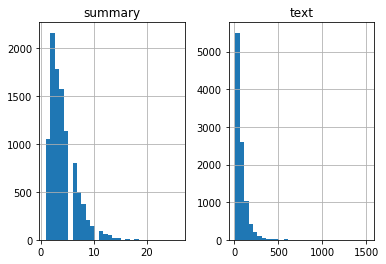

In [16]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['Text']:
      text_word_count.append(len(i.split()))

for i in data['Summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [17]:
max_len_text=80 
max_len_summary=10

### Preparing Tokenizer

In [18]:
X_train , X_test , y_train , y_test = train_test_split(data['cleaned_text'], data['cleaned_summary'], test_size=0.1, random_state=0, shuffle=True)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8991,)
(1000,)
(8991,)
(1000,)


#### Text Tokenizer

In [19]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(X_train))

#convert text sequences into integer sequences
X_train = x_tokenizer.texts_to_sequences(X_train) 
X_test = x_tokenizer.texts_to_sequences(X_test)

#padding zero upto maximum length
X_train = pad_sequences(X_train,  maxlen=max_len_text, padding='post') 
X_test = pad_sequences(X_test, maxlen=max_len_text, padding='post')

x_voc_size = len(x_tokenizer.word_index) +1

#### Summary Tokenizer

In [20]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

#convert summary sequences into integer sequences
y_train = y_tokenizer.texts_to_sequences(y_train) 
y_test = y_tokenizer.texts_to_sequences(y_test) 

#padding zero upto maximum length
y_train = pad_sequences(y_train, maxlen=max_len_summary, padding='post')
y_test = pad_sequences(y_test, maxlen=max_len_summary, padding='post')

y_voc_size = len(y_tokenizer.word_index) +1

In [21]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8991, 80)
(1000, 80)
(8991, 10)
(1000, 10)


# 4.0 Model

In [22]:
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim, trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_sequences=True, return_state=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim, trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 500)      8434000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 80, 500), (N 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

#### Model optimization

In [24]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

#### Model fitting

In [97]:
try:
    model = load_model('model.h5', custom_objects={'AttentionLayer': AttentionLayer})
    print("Model successfully loaded.")
except:
    print("Train Model...")
    history = model.fit([X_train, y_train[:,:-1]], 
                    y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:],
                    epochs=10,
                    callbacks=[es],
                    batch_size=256, 
                    validation_data=([X_test,y_test[:,:-1]],
                                     y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:])
                   )
    model.save('model.h5')
    print("Model saved")

Model successfully loaded.


# 5.0 Evaluation

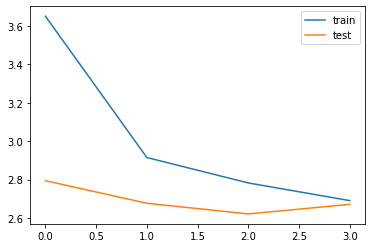

In [98]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend()
plt.show()

In [99]:
reverse_target_word_index = y_tokenizer.index_word 
reverse_source_word_index = x_tokenizer.index_word 
target_word_index = y_tokenizer.word_index

#### Inference

In [100]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2]
)

#### Inference Process

In [101]:
target_word_index['start']

1

In [102]:
X_test[0].reshape(1, -1)

array([[   3,    8,  154,    8,  996,  917, 1173,  169,  154,    2,  146,
         431,  154,    8, 5136,  517,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0]], dtype=int32)

In [103]:
for i in range(0, 3):
    print(encoder_model.predict(X_test[0].reshape(1, -1))[i].shape)

(1, 80, 500)
(1, 500)
(1, 500)


In [104]:
e_out, e_h, e_c = encoder_model.predict(X_test[0].reshape(1, -1))

In [105]:
target_seq = np.zeros((1,1))

target_seq[0, 0] = target_word_index['start']

target_seq

array([[1.]])

In [106]:
for i in range(0, 3):
    print(decoder_model.predict([target_seq] + [e_out, e_h, e_c])[i].shape)

(1, 1, 4247)
(1, 500)
(1, 500)


In [107]:
out, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

In [108]:
len(y_tokenizer.word_index)

4246

In [109]:
np.argmax(out[0, -1, :])

3

In [110]:
y_tokenizer.index_word[193]

'convenient'

In [111]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token != 'end'):
            decoded_sentence += ' ' + sampled_token

            # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [112]:
def seq2summary(input_seq):
    newString = ''
    
    for i in input_seq:
        if((i!=0 and i!= target_word_index['start']) and i != target_word_index['end']):
            newString = newString + reverse_target_word_index[i] + ' '
            
    return newString

def seq2text(input_seq):
    newString = ''
    
    for i in input_seq:
        if(i != 0):
            newString = newString + reverse_source_word_index[i] + ' '
            
    return newString

In [113]:
for i in range(10):
    print("Review:", seq2text(X_test[i]))
    print("Original summary:", seq2summary(y_test[i]))
    print("Predicted summary:", decode_sequence(X_test[i].reshape(1,max_len_text)))
    print("\n")

Review: good flavor coconut flavor subtle overpowering comparison another coconut coffee green mountain coconut flavor overdone opinion 
Original summary: good coffee 
Predicted summary:  great


Review: high amount protein specifically mentioned taurine label cats need decided use temporarily cats absolutely adore since found cat specific flavor company probably use little variety cats coats look feel shiny healthy definitely vomit less fed mainstream foods also mixed straight ground raw meat bone make sure getting plenty meat wild brushtail certainly seems agree protein source protein sources make sick brushtail wild grain fed thus plenty right nutrients also according company nuisance responsible way help brushtail devour animals live love 
Original summary: even cats love it 
Predicted summary:  great


Review: maybe miracle fruit work everyone little effect used started clear pallet let pill dissolve tongue etc tried classic first lime noticed barely quite pucker may without mberr